# Prédiction de la qualité d'un film à partir de ses caractéristiques

**Note importante :** \
Si vous lisez ce Notebook depuis l'interface GitHub, vous ne pourrez pas accéder à tout son contenu. Pour le visualiser en intégralité, nous vous invitons à vous rendre sur ce lien : https://nbviewer.org/github/Jeremstar/Succes_de_films-IMDb/blob/main/Notebook/Scrap_IMDb.ipynb \
Par ailleurs, si vous souhaitez exécuter le code, vous ne pourrez pas lancer le scraping (sauf à vous restreindre à un nombre limité de pages scrapées). Ce code est réalisé en conséquence. La base de donnée issue de notre scraping est disponible par téléchargement, ce que nous avons évidemment intégré à la rédaction.

## Présentation du projet
Le but de notre projet est de créer un modèle économétrique pour prédire le succès d'un film à partir de ses caractéristiques, comme sa durée, son genre, son réalisateur, etc. 

Nous avons décidé d'utiliser les données d'IMDb, un site de notation et de référencement des films. L'avantage de cette plateforme est qu'elle permet aux internautes de noter les films qu'ils ont vu, ce qui sera ce que l'on considère comme la mesure du succès d'un film. Par ailleurs, de nombreuses informations qui nous seront utiles sont présentes sur ce site et sont plus directement accessibles que sur une plateforme comme Wikipedia.

## Commençons par la mise en place du jeu de données
Nous importons une base mise à disposition par IMDb, que nous rendons exploitable par quelques opérations élémentaires.
Nous ne conservons que les films qui ont 2.000 votes ou plus : cela permet d'une part d'éviter de considérer les films trop peu votés pour que leur note moyenne soit pertinente, et d'autre part d'avoir un jeu de données plus léger.

In [1]:
import pandas as pd
movies_rating = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz")
movies_rating_clean = movies_rating["tconst\taverageRating\tnumVotes"].str.split("\\t", expand=True)
movies_rating_clean.columns = ['ID', 'Note_moyenne', 'Nombre_de_votes']
movies_rating_clean['Note_moyenne'] = movies_rating_clean['Note_moyenne'].astype(float)
movies_rating_clean['Nombre_de_votes'] = movies_rating_clean['Nombre_de_votes'].astype(float)
movies_rating_filtré = movies_rating_clean[movies_rating_clean.Nombre_de_votes > 1999]

**Nous voilà maintenant en possession d'une première base de travail**

Le problème de ce jeu de donné téléchargé, c'est qu'il ne contient que des informations sur les votes des films. Il n'y a aucune mention d'autres caractéristiques dont nous pourrons avoir besoin, comme son cast. Nous avons contacté les services d'IMDb, mais leur API est payant... Nous avons donc choisi de scraper les informations dont nous avons besoin.

Cela dit, la base téléchargée va nous être particulièrement utile ! Nous avons à disposition les identifiants de tous les films de la plateforme qui ont recueilli 2000 votes ou plus, et l'URL des pages des films s'écrit à partir de cet identifiant.

In [2]:
#On fabrique le squelette du dataframe que l'on va remplir au fur et à mesure du scrap ; on le fusionnera par la suite
#avec la database téléchargée plus tôt
#On indique le nom des colonnes, qui sont les variables que l'on choisit de conserver
#contentRating est la classification d'age, creator est la société de production
df = pd.DataFrame(columns=['name', 'alternateName', 'url', 'contentRating', 'datePublished', 'genre', 'actor', 'director',
                           'creator', 'Origine', 'Budget', 'duration', 'keywords'])

**La soupe à la grimace**


Après avoir essayé de scraper les éléments en cherchant des chemins d'accès manuellement dans le code HTML rendu sous forme de "soupe" par BeautifulSoup, nous avons trouvé dans chaque page un dictionnaire qui comprend les caractéristiques principales des films. Le code suivant permet de recueillir ces données, les traiter pour les rendre exploitables, et les insérer dans un dataframe.

Nous avions des ambitions assez importantes quant aux variables à retenir, mais certains éléments étaient intraçables dans la soupe que nous donne BeautifulSoup, étant donné que la fonction de recherche dans la soupe n'autorise que 6 arguments de path, ce qui est largement insuffisant au vu de la structure des pages IMDb (et nous pensons que cette architecture a été volontairement établie pour rediriger les scrapeurs vers l'API d'IMDb). Le dictionnaire que nous pouvons scraper ne contient malheureusement pas des données comme le budget, la langue d'origine, etc... ce qui expliquera le retrait de certaines colonnes, et de nombreuses interrogations lors de la visualisation des données.

Malgré tout, le code suivant permet d'obtenir les caractéristiques de quelques 46.000 pages IMDb.

ATTENTION : si vous souhaitez faire fonctionner ce code, modifiez-le pour ne considérer que quelques pages (bouclez sur moins d'ID). Il est impossible d'obtenir le résultat de ce scrap dans un temps raisonnable.

In [ ]:
from bs4 import BeautifulSoup as bs
import requests
from random import seed
import time
import json
import re


#C'est une liste des objets inutiles dans le scrap des pages ; je retire aussi le contenu du dataframe
#qu'on a déjà (les votes)
superflu = ["@context", "@type", "image", "description", "review", "trailer", "aggregateRating"]
#Celui-ci servira à retirer les images des scénaristes, etc
superflu2 = ['@type', 'url']

session_obj = requests.Session()


#On boucle sur chaque film qu'on considère
#Le compteur est cosmétique : il sert à nous rassurer sur le fait que tout se passe bien pendant le scrap
compteur = 0
for ID in movies_rating_filtré['ID'] :
  compteur = compteur+1
  print(compteur)
  try: #On utilise un try except au cas où on aurait un problème sur une page :
    #on ne veut pas que l'exécution s'arrête après des heures de scrap
    time.sleep(0.01) #On ajoute un petit délai pour ne pas surcharger le site de requêtes
    url_temp = 'https://www.imdb.com/title/'+ID+'/'
    response=session_obj.get(url_temp, headers={"User-Agent": "Mozilla/5.0"}) #On se fait passer pour une session normale 
    html = response.content
    soup = bs(html, "html.parser")
    
    #Le bloc est composé de la partie de chaque page qui contient les informations utiles
    #On le transforme en dictionnaire
    bloc = soup.find("script", type="application/ld+json").string
    dictio = json.loads(bloc)
    
    #On retire dedans ce qui ne nous intéresse pas
    for inutile in superflu :
      dictio.pop(inutile, None)

    #on ajoute une ligne budget illico presto ATTENTION CA NE MARCHE PAS
    liste_budg = soup.find_all("label", class_="ipc-metadata-list-item__list-content-item")
    if len(liste_budg) >= 3 and '$' in liste_budg[2] :
      budget = liste_budg[2].string
      if budget == None :
        budget = "Non renseigné"
      else :
        budget = "".join([elemnt for elemnt in budget if elemnt.isdigit()])
      dictio['Budget'] = budget

    #L'allure du dictionnaire n'est pas parfaitement satisfaisante, par exemple chaque acteur est associé à
    #une date de naissance,à une photo, etc... On ne conserve que le nom des acteurs, et celui des réalisateurs
    
    if 'actor' in dictio :
      for acteur in dictio['actor'] :
        for inutile in superflu2 :
          acteur.pop(inutile, None)
      for indice, nom in enumerate(dictio['actor']) :
        dictio['actor'][indice] = nom['name']

    if 'director' in dictio :
      for directeur in dictio['director'] :
        for inutile in superflu2 :
          directeur.pop(inutile, None)
      for indice, nom in enumerate(dictio['director']) :
        dictio['director'][indice] = nom['name']
    
    if 'creator' in dictio :
      for createur in dictio['creator'] :
        createur.pop('@type', None)
      for indice, url in enumerate(dictio['creator']) :
        dictio['creator'][indice] = url['url']

    #Pour la société de production c'est un peu compliqué : on n'a qu'une URL
    #Ce qui n'est pas grave, puisqu'on peut retrouver son nom en scrapant cet url !
    #Mais le temps d'exécution explose si on le fait ; j'inclus donc ce code (complètement fonctionnel)
    #mais en pratique il prend trop de temps à tourner
    
    if 'creator' in dictio :
      for index, createur in enumerate(dictio['creator']) :
        url_temp = 'https://www.imdb.com'+createur
        response=session_obj.get(url_temp, headers={"User-Agent": "Mozilla/5.0"})
        html = response.content
        soup = bs(html, "lxml")
        compagnie_soup = soup.find("title")
        if compagnie_soup == None :
          compagnie = "Non renseigné"
        else :
          compagnie = compagnie_soup.string
        compagnie = compagnie[5:-40] #on garde que l'élément important du titre
        dictio['creator'][index] = compagnie

    #On ajoute au dictionnaire le pays d'origine, que l'on le trouve dans la date de sortie
    date_sortie_soup = soup.find("a",
    class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link",
                                 href="/title/"+ID+"/releaseinfo?ref_=tt_dt_rdat")
    if date_sortie_soup == None :
      date_sortieV2 = "Non renseigné"
      pays = "Non renseigné"
    else :
      date_sortieV2 = date_sortie_soup.string
      b1 = date_sortieV2.find('(')
      b2 = date_sortieV2.find(')')
      pays = date_sortieV2[b1:b2]
      pays=pays[1:]
    dictio['Origine'] = pays

    #On ajoute dans le dataframe la ligne qui correspond au film
    df = df.append(dictio, ignore_index=True)
  except:
    print('Erreur au rang : '+str(compteur))

**Et voilà : nous avons construit une base de donnée grâce au scraping**

Nous ne conseillons pas de lancer ce code, puisqu'il nous a fallu plus d'une journée pour obtenir le dataframe, sans compter toutes les fois où notre ordinateur a eu des problèmes de connexion et interrompu l'exécution (ce qui nous a coûté au total 3 jours). En revanche, il est possible de le lancer sur quelques valeurs, pour obtenir un échantillon.

Nous mettrons à disposition le dataframe complet, pour pouvoir lancer le reste du code sans scraper à nouveau ces 46.000 pages.

**La prochaine étape est donc de fusionner les dataframes et de transformer la classe des objets de chaque colonne, pour les rendre exploitables**

Le code suivant permet d'importer le dataframe du scrap (*df*) et de le fusionner avec le dataframe téléchargé et traité (*movies_rating_filtré*), en fabriquant une colonne commune pour permettre la jointure. On prend également le soin de rendre les éléments des colonnes *actor* et *director* comme des listes. Ce code fonctionne malgré l'avertissement qu'il renvoie.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/Succes_de_films-IMDb/main/Database/IMDB_2000votes.csv', 
                 converters={"actor": lambda x: x.strip("[]").split(", "),
                             'director': lambda y : y.strip("[]").split(", ")}) 

movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'
df_fusionné = df.merge(movies_rating_filtré, on='url',how='left')

/tmp/ipykernel_36052/560150336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'


On ordonne ensuite les colonnes dans l'ordre que l'on souhaite, on supprime celles qui posent problème.

In [3]:
df_fusionné = df_fusionné.reindex(columns=['ID_y','name','alternateName','url','contentRating',
                                           'datePublished','genre','actor','director','creator','Origine','Budget',
                                           'duration','keywords','Note_moyenne','Nombre_de_votes','ID_x'])
#On drop creator, pour les questions de scrap évoquées plus tôt, et budget parce qu'il est impossible de l'obtenir avec
#uniquement 6 arguments de path comme le permet la library de scrap
df_fusionné =df_fusionné.drop(['ID_x', 'Budget', 'alternateName', 'creator'],axis=1) 
df_fusionné.rename(columns={'ID_y':'ID'}, inplace= True)

Certaines chaînes de caractères ne sont pas lisibles (on a par exemple des codes "&apos ;" au lieu de véritables apostrophes).
La fonction suivante permet de résoudre ces problèmes, à la fois dans les listes et les string.

In [4]:
def correcteur(colonne, old, new) :
    if type(df_fusionné[colonne][0]) == list :
        all_crews = []
        for crew in df_fusionné[colonne]:
            crew_corrigé = []
            if crew != [] :
                for individu in crew :
                    crew_corrigé.append(individu.replace(old, new))
            all_crews.append(crew_corrigé)
        df_fusionné[colonne] = all_crews
    else :
        df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new)

On applique donc cette fonction de correction à toutes les colonnes qui en ont besoin.

In [5]:
#Précisons qu'une apostrophe apparaît dans le notebook à la place du code & apos; en deuxième argument de la fonction
#en réalité, il s'agit évidemment du code du caractère à remplacer.
correcteur('actor', '&apos;', "'")
correcteur('director', '&apos;', "'")
correcteur('name', '&apos;', "'")

Nous aurons par la suite recours souvent à une fonction qui permet d'obtenir toutes les valeurs uniques que contient une colonne, qu'elle contienne des listes ou des éléments simples. Elle a beaucoup servi dans notre travail de construction, donc nous la présentons pour que la démarche soit claire.

In [6]:
from pandas.core.common import flatten

def valeurs_possibles (colonne) :
    list_nonflat = df_fusionné[colonne]
    flat_list = list(flatten(list_nonflat))
    liste_valeurs = list(set(flat_list))
    return liste_valeurs

Grâce à cette fonction donc, nous pouvons harmoniser plus facilement les classifications d'âge des films.

In [ ]:
valeurs_possibles('contentRating')

In [7]:
correcteur('contentRating', 'Tous Public', 'tous publics')
correcteur('contentRating', 'Tous Publics', 'tous publics')
correcteur('contentRating', 'Tous public', 'tous publics')
correcteur('contentRating', 'Tous publics', 'tous publics')
correcteur('contentRating', 'Not Rated', 'Not rated') #Absence de certificat
correcteur('contentRating', 'Unrated', 'Not rated') #Idem
correcteur('contentRating', '-12', '12')
correcteur('contentRating', '10 avec avertissement', '10')
correcteur('contentRating', '12 avec avertissement', '12')
correcteur('contentRating', 'Passed', 'Approved') #Classification d'avant 1968
correcteur('contentRating', '14+', '14')
correcteur('contentRating', '(Banned)', 'Banned')
correcteur('contentRating', '-16', '16')
correcteur('contentRating', 'TV-14', '14')
correcteur('contentRating', '16 avec avertissement', '16')
correcteur('contentRating', '-10', '10')
correcteur('contentRating', 'TV-PG', 'Accord parental')
correcteur('contentRating', 'PG-13', 'Accord parental')
correcteur('contentRating', 'M/PG', 'Accord parental')
correcteur('contentRating', 'PG', 'Accord parental')
correcteur('contentRating', '0+', 'tous publics')
correcteur('contentRating', 'E1Tous Publics+', 'tous publics')
correcteur('contentRating', 'E1Tous Public+', 'tous publics')
correcteur('contentRating', 'TV-13', '13')
correcteur('contentRating', 'R', '18')
correcteur('contentRating', 'GP', 'Accord parental')
correcteur('contentRating', 'MA-17', '17')
correcteur('contentRating', 'X', '18')
correcteur('contentRating', 'TV-Y7-FV', '7')
correcteur('contentRating', 'TV-Y7', '7')
correcteur('contentRating', 'TV-G', 'Tous Public')
correcteur('contentRating', 'G', 'Tous Public')
correcteur('contentRating', 'Tous Publics', 'tous publics')
correcteur('contentRating', 'Tout public', 'tous publics')
correcteur('contentRating', '1Tous Public', 'tous publics')
correcteur('contentRating', 'Tous Public+', 'tous publics')
correcteur('contentRating', 'NC-17', '18')
correcteur('contentRating', 'TV-MA', '18')
correcteur('contentRating', 'TV-T', 'tous publics')
correcteur('contentRating', 'M', '18')
correcteur('contentRating', 'E', 'Éducatif')
correcteur('contentRating', 'T', 'tous publics')
correcteur('contentRating', 'K-A', 'Erreur')
correcteur('contentRating', 'AO', 'Erreur')
correcteur('contentRating', 'Open', 'Erreur')
correcteur('contentRating', 'tous publicsV-Y', 'tous publics')
correcteur('contentRating', 'Éducatif1tous publics+', 'tous publics')
correcteur('contentRating', 'tous publicss avec avertissement', 'tous publics')
correcteur('contentRating', '1tous publics', 'tous publics')
correcteur('contentRating', 'tous publicss', 'tous publics')

/tmp/ipykernel_36052/534507345.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new)


Cette procédure est fastidieuse mais il est difficile de faire autrement pour harmoniser.

On convertit à présent les mois, pour les numéroter de 1 à 12.

In [8]:
df_fusionné['month'] = pd.DatetimeIndex(df_fusionné['datePublished']).month

On convertit ensuite la durée du film, pour passer par exemple de "PT1H32M" au nombre de minutes du film. Par souci de lisibilité, on construit d'abord une fonction de recodage, que l'on applique ensuite à la colonne.

In [9]:
def recodage_duree(duree) :
    if type(duree) == str :
        duree = duree[2:]
        if 'H' not in duree :
            duree_corrigee = int(duree[-3:-1])
        elif 'M' not in duree :
            duree_corrigee = int(duree[-2:-1])*60
        else :
            heures = int(duree[0])*60
            duree = duree[2:]
            minutes = int(duree[-3:-1])
            duree_corrigee = heures + minutes
    else :
        duree_corrigee = None
    return duree_corrigee

In [10]:
df_fusionné['duration']=df_fusionné['duration'].apply(lambda row : recodage_duree(row))

À présent, on transforme les dates avec un véritable format date. On fait le choix d'écarter les 700 films pour lesquels la date n'est pas renseignée, en considérant qu'ils sont minoritaires.

In [11]:
index_with_nan = df_fusionné.index[df_fusionné.loc[:,'datePublished'].isnull()]
df_fusionné.drop(index_with_nan,0, inplace=True)
df_fusionné = df_fusionné.sort_values(by='datePublished')
df_fusionné = df_fusionné.reset_index(drop = True)

/tmp/ipykernel_36052/2112836509.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_fusionné.drop(index_with_nan,0, inplace=True)


In [12]:
import datetime
df_fusionné['datePublished'] = df_fusionné['datePublished'].apply(lambda x : datetime.datetime.strptime(str(x), '%Y-%m-%d'))

**Le jeu de donné est à présent suffisamment propre pour être exploitable !** Affichons le pour voir son allure.

In [75]:
df_fusionné

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,keywords,Note_moyenne,Nombre_de_votes,month
0,tt2221420,Sallie Gardner at a Gallop,/title/tt2221420/,tous publics,1878-06-15,"['Documentary', 'Short']","['Gilbert Domm', 'Sallie Gardner']",['Eadweard Muybridge'],United States,1.0,"19th century,1870s,nature,horse,first of its kind",7.4,3097.0,6.0
1,tt0392728,Roundhay Garden Scene,/title/tt0392728/,Not rated,1888-10-14,"['Documentary', 'Short']","['Annie Hartley', 'Adolphe Le Prince', 'Joseph...",['Louis Aimé Augustin Le Prince'],United Kingdom,1.0,"place name in title,first of its kind,year 188...",7.3,6255.0,10.0
2,tt0000005,Blacksmith Scene,/title/tt0000005/,Not rated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,1.0,"blacksmith,national film registry,beer,two wor...",6.2,2556.0,5.0
3,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,1.0,"national film registry,year 1894,1890s,19th ce...",5.4,2073.0,1.0
4,tt0177707,Dickson Experimental Sound Film,/title/tt0177707/,Not rated,1894-08-31,"['Short', 'Music']",['William K.L. Dickson'],['William K.L. Dickson'],United States,22.0,"same sex dance partners,gay interest,national ...",6.7,2378.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46076,tt14208870,The Fabelmans,/title/tt14208870/,Accord parental,2023-01-25,['Drama'],"['Michelle Williams', 'Gabriel LaBelle', 'Paul...",['Steven Spielberg'],France,151.0,"arizona,coming of age,childhood,father son rel...",7.9,10470.0,1.0
46077,tt14444726,Tár,/title/tt14444726/,18,2023-02-22,"['Drama', 'Music']","['Cate Blanchett', 'Noémie Merlant', 'Nina Hoss']",['Todd Field'],France,158.0,"female rear nudity,classical music,character n...",7.8,11630.0,2.0
46078,tt13833688,The Whale,/title/tt13833688/,18,2023-03-08,['Drama'],"['Brendan Fraser', 'Sadie Sink', 'Ty Simpkins']",['Darren Aronofsky'],France,117.0,"screenplay adapted by author,overweight man,ga...",8.3,5268.0,3.0
46079,tt4960748,Till,/title/tt4960748/,Accord parental,2023-03-22,"['Biography', 'Drama', 'History']","['Danielle Deadwyler', 'Jalyn Hall', 'Frankie ...",['Chinonye Chukwu'],France,130.0,"year 1955,based on real people,1950s,justice,m...",7.2,3964.0,3.0


## Premier parcours du jeu de données : quelques statistiques descriptives

Commençons par établir quelques statistiques fondamentale pour avoir un aperçu un peu plus détaillé de la base de donnée. Gardons à l'esprit, pour cette partie et pour toutes celles qui suivront, que les résultats sont à interpréter avec précaution étant donné que nous n'avons retenu, arbitrairement, que les films qui ont reçu 2.000 votes ou plus.

**Répartition générale des votes**

In [13]:
df_fusionné[['Note_moyenne','Nombre_de_votes']].describe()

,Note_moyenne,Nombre_de_votes
count,46080.000000,4.608000e+04
mean,6.983830,2.525578e+04
std,1.303673,8.693589e+04
min,1.000000,2.000000e+03
25%,6.200000,2.906000e+03
50%,7.100000,4.712000e+03
75%,7.900000,1.257250e+04
max,10.000000,2.672354e+06


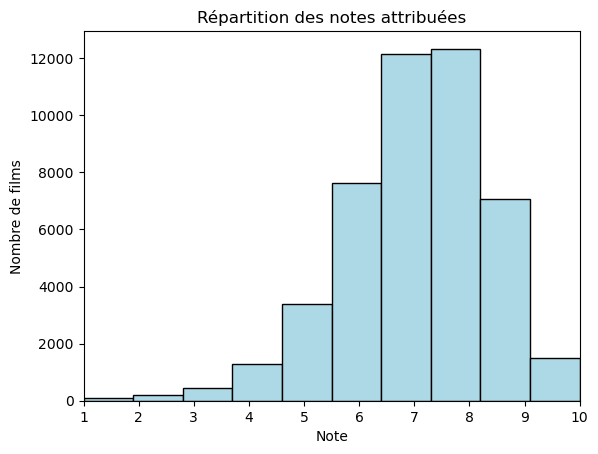

In [14]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(df_fusionné['Note_moyenne'], facecolor='lightblue', ec='black')
plt.xlabel('Note')
plt.ylabel('Nombre de films')
plt.title('Répartition des notes attribuées')
plt.xlim(1, 10)
plt.show()

Nous avons un total de 46.081 films, dont la note moyenne est d'un peu moins de 7 (un film "moyen" n'est donc pas noté 5). La moyenne du nombre de votes est de 2.500, ce qui indique que la majorité des films reçoivent peu de votes. De la même manière, en filtrant à 2.000 votes les films retenus, nous avions laissé de côté plus de la moitié des films. Cela correspond au phénomène de *long tail* : très peu de films reçoivent un grand nombre de votes, et beaucoup en reçoivent peu. De fait, le filtre de 2.000 vote nous prive d'une large variété de films, mais étant donnés nos moyens techniques, nous ne pouvons pas faire autrement, et le filtre est raisonnable.

**Durée des films**

In [15]:
df_fusionné.dropna(inplace = False)['duration'].describe()

count    34288.000000
mean        86.079007
std         36.304117
min          1.000000
25%         55.000000
50%         93.000000
75%        108.000000
max        583.000000
Name: duration, dtype: float64

Le film moyen de cette base de données dure 1h26. Le plus long dure presque 10h. Restons prudents en interprétant cette moyenne : une majorité de films de la fin du XIXe/début XXe sont des courts-métrages, comme l'indique le graphique suivant :

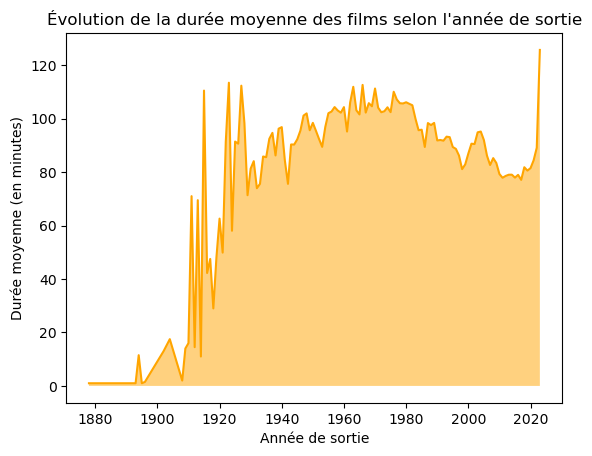

In [16]:
import math
# Sélectionnons les colonnes de durée et de date de sortie de votre dataframe
durations = df_fusionné['duration']
release_dates = df_fusionné['datePublished']

# Créons un dictionnaire qui contient les durées moyennes par année de sortie
average_durations = {}
for date, duration in zip(release_dates, durations):
    if not math.isnan(duration) :  # Vérifions si la durée est renseignée
        year = date.year
        if year in average_durations:
            average_durations[year].append(duration)
        else:
            average_durations[year] = [duration]

# Calculons la durée moyenne pour chaque année de sortie
average_durations = {year: sum(durations)/len(durations) for year, durations in average_durations.items()}

# Récupérons les années et les durées moyennes pour tracer le graphique
years = list(average_durations.keys())
averages = list(average_durations.values())

# Créons la courbe
plt.plot(years, averages, color='orange')
plt.fill_between(years, averages, facecolor='orange', alpha=0.5)

# Ajoutons un titre et des noms aux axes
plt.xlabel('Année de sortie')
plt.ylabel('Durée moyenne (en minutes)')
plt.title('Évolution de la durée moyenne des films selon l\'année de sortie')

# Affichons le graphique
plt.show()

Ces données représentent bien la manière dont le cinéma s'est développé, avec des films de plus en plus longs. On remarque toutefois une baisse de la durée moyenne des films à partir des années 1970.

**L'histoire du cinéma au travers du nombre de films sortis**

On peut discuter du développement du cinéma de manière plus directe, en présentant l'évolution du nombre de films sortis par année grâce au graphique suivant :

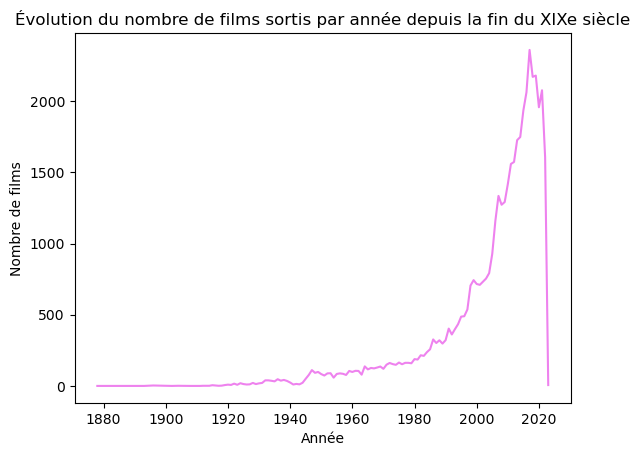

In [78]:
films_par_annee = df_fusionné.groupby(df_fusionné["datePublished"].dt.year).size()
plt.plot(films_par_annee, color='violet')
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.title('Évolution du nombre de films sortis par année depuis la fin du XIXe siècle')
plt.show()

Cette allure indique bien la manière dont le cinéma s'est développé historiquement. D'abord de manière expérimentale à la fin du XIXe : par exemple, le premier film de notre base de donnée est *Sallie Gardner at a Gallop*, et le but de son créateur était une expérience photographique qui visait à étudier scientifiquement le mouvement. Il se développe ensuite dans une optique de divertissement dans les années 1920, mais au États-Unis uniquement. Après la Seconde Guerre mondiale, il s'exporte en Europe, d'où son développement plus accentué. Le nombre de films explose à la fin du XXe siècle. De nos jours, les plateformes de visionnage en ligne portent encore son développement. Le creux à la fin de la période est lié au fait que les données de l'années en cours ne sont pas complètes (même si l'effet des confinements en 2020 peut être observé).

**Effets de mode**

Nous pouvons étudier différentes modes dans le temps, mais avec précaution. Puisque nous disposons de "keywords", nous pouvons étudier l'évolution de la présence de certains thème dans le temps, mais l'évolution du nombre de films publiés par année ne peut que nous convaincre d'étudier cette présence non pas en termes absolus mais relatifs. C'est-à-dire d'étudier non pas le nombre de films qui portent sur un thème, mais leur proportion dans le nombre de sorties total.

/tmp/ipykernel_4319/602806038.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_femmefatale['year'] = df_femmefatale['datePublished'].dt.year


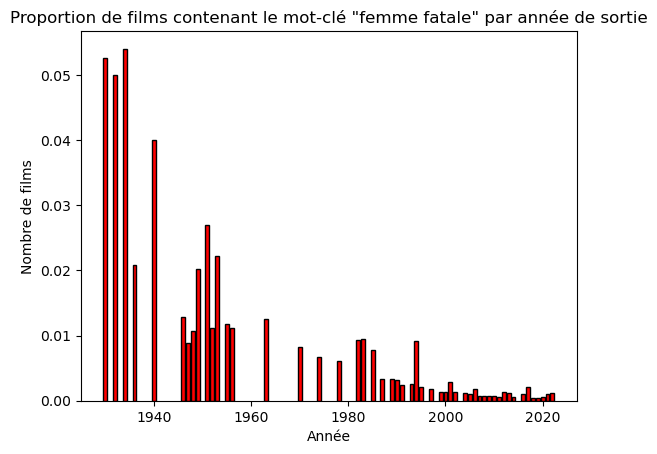

In [79]:
df_fusionné['keywords'] = df_fusionné['keywords'].fillna('')
# Filtrons le dataframe pour ne garder que les films qui ont le mot clé "femme fatale"
df_femmefatale = df_fusionné[df_fusionné['keywords'].str.contains('femme fatale')]

# Ajoutons une colonne qui contient le mois de sortie de chaque film
df_femmefatale['year'] = df_femmefatale['datePublished'].dt.year

# Groupby le dataframe par mois de sortie et compte du nombre de films pour chaque mois
counts = df_femmefatale.groupby('year').size()
#Raisonnement par proportion, où films_par_annee a été défini dans le bloc précédent
proportion = counts/films_par_annee

# Créons l'histogramme
plt.bar(proportion.index, proportion.values, facecolor='red', ec='black')
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.title('Proportion de films contenant le mot-clé "femme fatale" par année de sortie')
plt.show()

/tmp/ipykernel_4319/2432602826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_western['year'] = df_western['datePublished'].dt.year


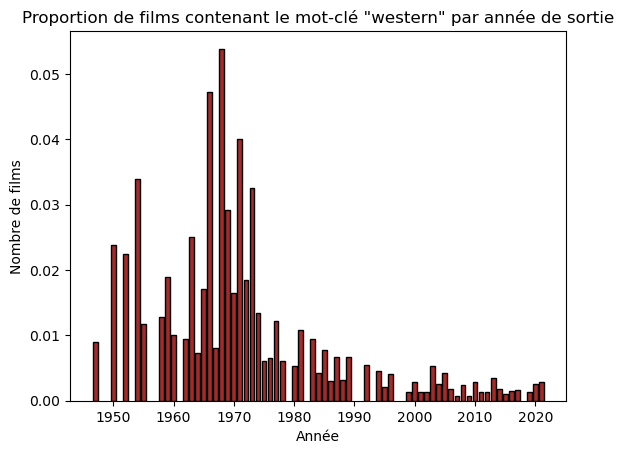

In [80]:
df_western = df_fusionné[df_fusionné['keywords'].str.contains('western')]
df_western['year'] = df_western['datePublished'].dt.year
counts = df_western.groupby('year').size()
proportion = counts/films_par_annee

plt.bar(proportion.index, proportion.values, facecolor='brown', ec='black')
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.title('Proportion de films contenant le mot-clé "western" par année de sortie')
plt.show()

On observe bien les effets de mode grâce à ce genre de graphiques. La figure de la femme fatale a connu un période de popularité dans la première moitié du XXe siècle. On pense par exemple à la performance de Kim Novak dans le film d'Hitchcock *Sueurs froides*. Au fil du temps, l'intérêt pour ce film s'est estompé. De même, on peut observer la manière dont la mode des westerns apparaît à la fin des années 1960 puis s'essouffle.

La période de publication d'un film est ainsi très importante pour expliquer son succès. De façon similaire, le moment de l'année où un film sort a son importance. L'industrie sait s'emparer de l'opportunité de certains évènements, comme Noël :

/tmp/ipykernel_4319/1776000058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_christmas['month'] = df_christmas['datePublished'].dt.month


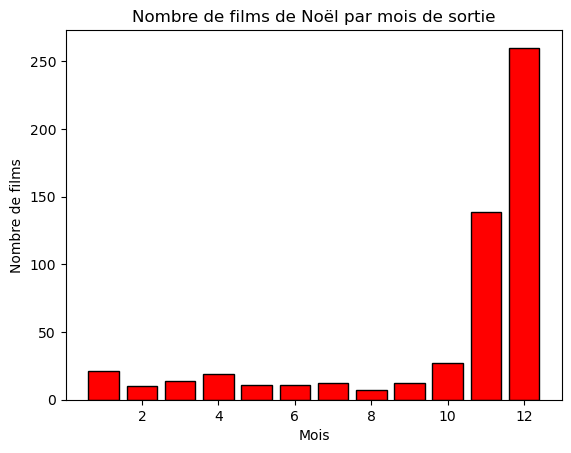

In [81]:
df_fusionné['keywords'] = df_fusionné['keywords'].fillna('')
df_christmas = df_fusionné[df_fusionné['keywords'].str.contains('christmas')]
df_christmas['month'] = df_christmas['datePublished'].dt.month
counts = df_christmas.groupby('month').size()

plt.bar(counts.index, counts.values, facecolor='red', ec='black')
plt.xlabel('Mois')
plt.ylabel('Nombre de films')
plt.title('Nombre de films de Noël par mois de sortie')
plt.show()

**Loisir saisonnier**

On peut penser que la diffusion des films est concentrée sur certaines périodes où la population a davantage de temps à accorder au cinéma :

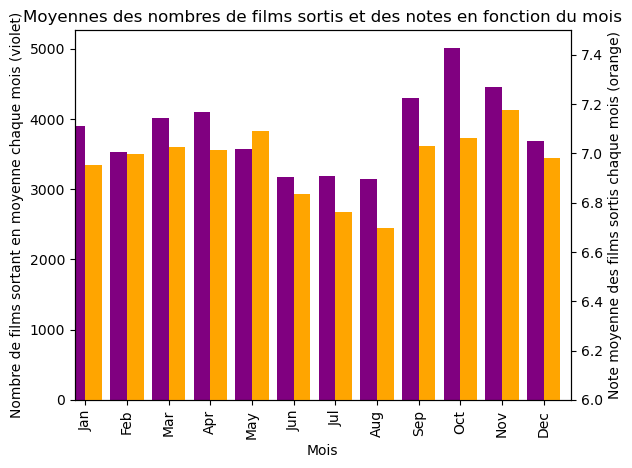

In [82]:
import calendar
#On recode le nom des mois
df_fusionné['month'] = df_fusionné['month'].astype(int)
df_fusionné['month_name'] = df_fusionné['month'].apply(lambda x: calendar.month_abbr[x])

#On établit le nombre de films sortis par mois
films_par_mois = df_fusionné.groupby('month_name')['ID'].count().rename_axis('month_name').reset_index(name='nb_films')
films_par_mois = films_par_mois.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

#De peut alors obtenir la note moyenne des films sortis chaque mois
notes_par_mois = df_fusionné.groupby('month_name')['Note_moyenne'].mean().rename_axis('month_name').reset_index(name='note_moyenne')
notes_par_mois = notes_par_mois.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

#On joint les deux jeux de donnés
nb_notes_par_mois = films_par_mois.merge(notes_par_mois,on='month_name',how='left')
nb_notes_par_mois = nb_notes_par_mois.set_index('month_name')

graph = plt.figure()

ax = graph.add_subplot(111)
ax2 = ax.twinx()

nb_notes_par_mois['nb_films'].plot(kind='bar',color='purple',ax=ax,width=0.4,position = 1)
nb_notes_par_mois['note_moyenne'].plot(kind='bar',color='orange',ax=ax2,width=0.4,position = 0)
ax.set_ylabel('Nombre de films sortant en moyenne chaque mois (violet)')
ax.set_xlabel('Mois')
ax2.set(ylim=[6,7.5], ylabel = 'Note moyenne des films sortis chaque mois (orange)')
plt.title('Moyennes des nombres de films sortis et des notes en fonction du mois')
plt.show()

On remarque nettement que les films sortent plutôt l'hiver que l'été. Le cinéma est donc un loisir saisonnier. Par ailleurs, la note des films semble être plus importante sur les mois où plus de films sortent. On peut émettre l'hypothèse que l'industrie sort ses films les plus ambitieux aux mois qu'elle juge les plus opportuns, c'est-à-dire pendant les mois de haute fréquentation. 

Quoi qu'il en soit, le mois de sortie apparaît comme une variable intéréssante pour prédire la note que recevra un film.

On peut aussi se demander si les films les mieux notés sont ceux qui ont été les plus vus.

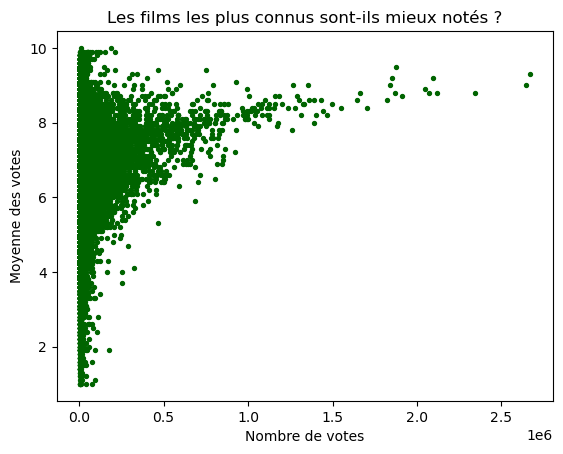

In [83]:
df_fusionné.plot(x='Nombre_de_votes', y='Note_moyenne', kind='scatter', s=8, c='#006400')
plt.title("Les films les plus connus sont-ils mieux notés ?")
plt.xlabel("Nombre de votes")
plt.ylabel("Moyenne des votes")
plt.show()

La réponse semble être plutôt positive, bien que l'on n'apprenne rien du sens de la corrélation. Cependant, nous ne pourrons pas intégrer directement le nombre de votes d'un film à notre prédiction : nous voudrions prédire le succès des films avant qu'ils soient votés. Mais, si effectivement le mois de sortie du film est corrélé à son nombre d'entrée, il pourrait en être un proxy.

**Origine des fims**

In [84]:
df_fusionné.groupby('Origine').size()

Origine
Albania           1
Argentina       102
Armenia           3
Australia       278
Austria          14
               ... 
Venezuela         4
Vietnam          13
West Germany     40
World-wide        2
Yugoslavia       17
Length: 103, dtype: int64

On remarque que les pays avec le plus grand nombre de films sont la France et les États-Unis. Certains pays ont très peu de films recensés, comme l'Albanie. D'autres sont des pays disparus, comme la Yougoslavie. Essayons tout de même de représenter ces données sur une carte.

In [85]:
import geopandas
import folium

#On crée un df avec uniquement les origines et les notes du film
df_pays_note_indiv = df_fusionné.loc[:,['Origine', 'Note_moyenne']]
#On crée un df avec une seule occurence de chaque pays et la note moyenne associée
df_pays_moyenne = df_pays_note_indiv.groupby('Origine').count()
#On renomme pour que le module fonctionne bien
df_pays_moyenne = df_pays_moyenne.rename(index={'United States': 'United States of America'})
#On importe la base de données géopanda avec les cordonnées spatiales, il va falloir la fusionner
#avec notre dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#Fusion de notre base et de celle de geopanda
geopanda_et_nos_données = world.merge(df_pays_moyenne, how='left', left_on=['name'], right_on=['Origine'] )
#On ne garde que les pays où il y a une note
geopanda_et_nos_données = geopanda_et_nos_données.dropna(subset=['Note_moyenne']) 
carte_note_pays=folium.Map()
folium.Choropleth(
    geo_data=geopanda_et_nos_données,
    name='choropleth',
    data=geopanda_et_nos_données,
    columns=['name', 'Note_moyenne'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Nombre de films issus de ce pays'
).add_to(carte_note_pays)
carte_note_pays

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


*Utilité de la datavisualisation*

C'est grâce à cette visualisation des données que nous nous appercevons d'une grande lacune de nos données. La France est effectivement un grand pays de cinéma, mais elle ne détrône pas les États-Unis. En réalité, les noms de pays que l'on a scrapé ne correspondent pas à l'origine d'un film. Ils proviennent d'une ligne qui indique leur date de sortie, et le pays associé à cette date. Le site semble détecter notre localisation, et afficher la date de sortie en France si le film connait une distribution internationale. L'origine d'*Harry Potter* est française par exemple. Autrement dit, en dehors de la France, les pays indiqués doivent être ceux des films qui connaissent une distribution exclusive à ce pays. 

Nous perdons donc à nouveau une variable d'intérêt, sauf à confondre films français et films à distribution internationale.

**Popularité des acteurs et réalisateurs**

Le casting d'un film et son réalisateur sont très importants pour déterminer si un film sera bien noté ou non. Toutefois, il est très difficile de faire une régression directement sur les acteurs. Nous avons donc essayé de construire un indicateur pour chaque acteur et réalisateur. Sa structure est un peu arbitraire, mais elle permet de tenir compte de différents paramètres importants.

Sa construction est la suivante :

-le score de chaque individu est initialisé à 5 (soit un peu moins que la note moyenne des films)

-il évolue à chaque film de l'individu, selon la note reçue par le film (on a un score par individu et par film)

-des poids sont ajoutés : plus la place de l'individu est marginale dans le casting, moins la note du film en question altère son score

-plus le film en question est ancien par rapport au film considéré, moins sa note est importante

Ce score a été difficile à construire, mais nous avons fini par obtenir un code qui s'exécute en moins d'une minute. Le premier bloc sert à construire le dictionnaire qui associe chaque acteur à tous ses scores :

In [17]:
#D'abord, on ordonne le dataframe par date de publication
df_fusionné = df_fusionné.sort_values(by='datePublished')
#On initialise le dictonnaire à utiliser
actor_scores = {}
#On parcourt le df ; on considère la liste des acteurs et la note moyenne
for _, row in df_fusionné.iterrows():
    actors = row['actor']
    rating = row['Note_moyenne']
    #On parcourt la liste des acteurs
    for i, actor in enumerate(actors):
        if actor not in actor_scores:
            # Si l'acteur n'a joué dans aucun film précédemment, son score initial est de 5
            actor_scores[actor] = []
        #On crée le score. Il est calculé comme : la somme du score à la période précédente, et de la note
        #du dernier film, multipliée par i+1 (de sorte à donner plus de poids aux films récents).
        #On divise ensuite par i+2, à la manière d'une moyenne pondérée. Les valeurs du score sont donc
        #comprises entre 1 et 10, et en général entre 5 et 10 sauf film catastrophique
        new_score = (actor_scores[actor][-1] + rating * (i + 1)) / (i + 2) if actor_scores[actor] else 5
        actor_scores[actor].append(new_score)

In [18]:
#Il existe un acteur '' dans le dictionnaire, c'est à cause des listes vides
#Ça ne ressemble à rien et pose bien des problèmes, on l'efface
actor_scores.pop('')

[5,
 5.95,
 6.825,
 7.112500000000001,
 7.65625,
 7.628125,
 7.2640625,
 7.532031249999999,
 7.616015624999999,
 6.4580078125,
 7.07900390625,
 5.389501953125,
 7.1447509765625,
 7.22237548828125,
 7.861187744140625,
 7.730593872070312,
 7.815296936035156,
 8.107648468017578,
 8.653824234008788,
 8.926912117004393,
 8.513456058502197,
 8.406728029251099,
 8.45336401462555,
 8.076682007312774,
 7.738341003656387,
 8.169170501828194,
 8.584585250914097,
 8.542292625457048,
 9.021146312728524,
 8.61057315636426,
 8.355286578182131,
 8.527643289091065,
 8.713821644545533,
 8.756910822272767,
 8.178455411136383,
 7.939227705568191,
 7.569613852784096,
 7.734806926392048,
 7.667403463196024,
 7.733701731598012,
 7.516850865799006,
 6.958425432899503,
 7.629212716449752,
 7.814606358224876,
 7.457303179112438,
 7.228651589556219,
 8.36432579477811,
 8.432162897389055,
 7.966081448694528,
 7.5830407243472635,
 7.991520362173632,
 7.145760181086816,
 7.322880090543408,
 7.511440045271704,
 7.45

In [19]:
#Pas nécéssaire de le lancer, mais affiche le dictionnaire en question
actor_scores

{"'Gilbert Domm'": [5],
 "'Sallie Gardner'": [5],
 "'Annie Hartley'": [5],
 "'Adolphe Le Prince'": [5],
 "'Joseph Whitley'": [5],
 "'Charles Kayser'": [5],
 "'John Ott'": [5],
 "'Fred Ott'": [5],
 "'William K.L. Dickson'": [5],
 "'Annabelle Moore'": [5],
 "'Robert Thomae'": [5],
 "'Mrs. Robert L. Thomas'": [5],
 "'Madeleine Koehler'": [5],
 "'Marcel Koehler'": [5],
 "'Mrs. Auguste Lumiere'": [5],
 "'Auguste Lumière'": [5],
 "'May Irwin'": [5],
 "'John C. Rice'": [5],
 "'Jehanne d'Alcy'": [5, 6.875],
 "'Jules-Eugène Legris'": [5],
 "'Georges Méliès'": [5, 6.6, 7.05, 7.324999999999999],
 "'Victor André'": [5],
 "'Bleuette Bernon'": [5],
 "'Gilbert M. 'Broncho Billy' Anderson'": [5, 6.275],
 "'A.C. Abadie'": [5],
 "'George Barnes'": [5],
 "'Fernande Albany'": [5],
 "'Frank Powell'": [5],
 "'Grace Henderson'": [5],
 "'James Kirkwood'": [5],
 "'Mary Fuller'": [5],
 "'Charles Ogle'": [5],
 "'Augustus Phillips'": [5],
 "'Salvatore Papa'": [5],
 "'Arturo Pirovano'": [5],
 "'Giuseppe de Liguoro

Les deux prochains blocs permettent d'inclure pour chaque film la liste des scores corresondants, c'est-à-dire pour chaque acteur et à un moment donné.

In [20]:
#On initialise la colonne liste_scores
df_fusionné['liste_scores'] = None
#Cette fonction permet de remplacer les listes vides par un None. Elle peut servir aussi pour le director
def replace_empty_list(x):
    if x == ['']:
        return None
    return x
#On remplace les listes d'acteur vides par des None
df_fusionné['actor'] = df_fusionné['actor'].apply(replace_empty_list)

In [21]:
#On parcourt le dataframe par ligne
for index, row in df_fusionné.iterrows():
    #print(index) - cette commande permet de se rassurer sur l'exécution du code, mais en vrai
    #il est suffisamment rapide pour ne pas paniquer
    liste_scores = []
    if type(row['actor']) == list : #on parcourt la liste des acteurs s'il y en a une
        for acteur in row['actor']: #pour chaque acteur du cast
            liste_scores.append(actor_scores[acteur][0]) #on ajoute le premier score du dico à la liste
            actor_scores[acteur].pop(0) #et on efface cette valeur:donc on peut toujours boucler sur la valeur 1
        df_fusionné.at[index, 'liste_scores'] = liste_scores #on intègre la liste obtenue
    else :
        df_fusionné.at[index, 'liste_scores'] = None #si on n'a pas d'acteur, on n'a pas de liste de score

Finalement, ce dernier bloc ajoute une colonne en quelque sorte de score du casting à chaque film, en donnant plus d'importance aux acteurs principaux du film.

In [22]:
def moyenne_pondérée(liste):
    if type(liste) == list :
        resultat = 0
        for i, score in enumerate(liste):
            resultat += score / (i + 2)
    else :
        resultat = None
    return resultat

df_fusionné['score_acteur'] = None
df_fusionné['score_acteur'] = df_fusionné['liste_scores'].apply(moyenne_pondérée)

In [91]:
#pour voir l'allure du score du casting
df_fusionné['score_acteur']

0        4.166667
1        5.416667
2        4.166667
3        2.500000
4        2.500000
           ...   
46076    7.793651
46077    7.891405
46078    7.889788
46079    6.629276
46080    5.416667
Name: score_acteur, Length: 46081, dtype: float64

On reproduit l'opération sur les réalisateurs. On n'a pas créé de fonction pour synthétiser parce quelques détails diffèrent, mais il n'y a pas grand-chose à commenter, si ce n'est le fait que beaucoup de films n'ont pas de réalisateur renseigné.

In [23]:
director_scores = {}
for _, row in df_fusionné.iterrows():
    directors = row['director']
    rating = row['Note_moyenne']
    for i, director in enumerate(directors):
        if director not in director_scores:
            director_scores[director] = []
        new_score = (director_scores[director][-1]+rating*(i+1))/(i+2) if director_scores[director] else 5
        director_scores[director].append(new_score)

In [24]:
director_scores.pop('') #beaucoup de films dont le réalisateur n'est pas renseigné

[5,
 6.0,
 6.85,
 7.375,
 8.3875,
 6.4937499999999995,
 7.546875,
 6.8234375,
 7.61171875,
 7.605859375,
 8.0029296875,
 8.15146484375,
 8.125732421875,
 8.3128662109375,
 7.50643310546875,
 7.653216552734374,
 7.126608276367187,
 7.113304138183594,
 7.756652069091797,
 8.178326034545899,
 7.78916301727295,
 6.694581508636475,
 6.647290754318237,
 6.9736453771591185,
 7.036822688579559,
 7.7184113442897795,
 7.75920567214489,
 8.129602836072445,
 7.664801418036223,
 8.082400709018112,
 8.241200354509056,
 8.120600177254527,
 7.5603000886272635,
 7.780150044313632,
 7.640075022156816,
 7.570037511078408,
 8.085018755539204,
 7.942509377769602,
 7.471254688884801,
 7.4356273444424,
 7.317813672221201,
 7.7589068361106,
 8.4294534180553,
 7.66472670902765,
 7.482363354513825,
 7.641181677256912,
 7.020590838628456,
 7.310295419314228,
 7.805147709657114,
 7.952573854828557,
 7.7762869274142785,
 7.588143463707139,
 6.944071731853569,
 7.322035865926784,
 7.511017932963393,
 7.905508966481

In [25]:
df_fusionné['liste_scores2'] = None
df_fusionné['director'] = df_fusionné['director'].apply(replace_empty_list)

In [26]:
for index, row in df_fusionné.iterrows():
    liste_scores2 = []
    if type(row['director']) == list :
        for directeur in row['director']:
            if directeur != None :
                liste_scores2.append(director_scores[directeur][0])
                director_scores[directeur].pop(0)
        df_fusionné.at[index, 'liste_scores2'] = liste_scores2
    else :
        df_fusionné.at[index, 'liste_scores2'] = None

In [27]:
df_fusionné['score_director'] = None
df_fusionné['score_director'] = df_fusionné['liste_scores2'].apply(moyenne_pondérée)

On peut finalement afficher le dataframe, enrichi de nos nouveaux indicateurs.

In [28]:
df_fusionné

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,keywords,Note_moyenne,Nombre_de_votes,month,liste_scores,score_acteur,liste_scores2,score_director
0,tt2221420,Sallie Gardner at a Gallop,/title/tt2221420/,tous publics,1878-06-15,"['Documentary', 'Short']","['Gilbert Domm', 'Sallie Gardner']",['Eadweard Muybridge'],United States,1.0,"19th century,1870s,nature,horse,first of its kind",7.4,3100.0,6.0,"[5, 5]",4.166667,[5],2.500000
1,tt0392728,Roundhay Garden Scene,/title/tt0392728/,Not rated,1888-10-14,"['Documentary', 'Short']","['Annie Hartley', 'Adolphe Le Prince', 'Joseph...",['Louis Aimé Augustin Le Prince'],United Kingdom,1.0,"place name in title,first of its kind,year 188...",7.3,6257.0,10.0,"[5, 5, 5]",5.416667,[5],2.500000
2,tt0000005,Blacksmith Scene,/title/tt0000005/,Not rated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,1.0,"blacksmith,national film registry,beer,two wor...",6.2,2557.0,5.0,"[5, 5]",4.166667,[5],2.500000
3,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,1.0,"national film registry,year 1894,1890s,19th ce...",5.4,2074.0,1.0,[5],2.500000,[5.2],2.600000
4,tt0177707,Dickson Experimental Sound Film,/title/tt0177707/,Not rated,1894-08-31,"['Short', 'Music']",['William K.L. Dickson'],['William K.L. Dickson'],United States,22.0,"same sex dance partners,gay interest,national ...",6.7,2379.0,8.0,[5],2.500000,[5.95],2.975000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46076,tt14208870,The Fabelmans,/title/tt14208870/,Accord parental,2023-01-25,['Drama'],"['Michelle Williams', 'Gabriel LaBelle', 'Paul...",['Steven Spielberg'],France,151.0,"arizona,coming of age,childhood,father son rel...",7.9,11435.0,1.0,"[6.996445428769727, 6.933333333333334, 7.93726...",7.793651,[7.5532039568293845],3.776602
46077,tt14444726,Tár,/title/tt14444726/,18,2023-02-22,"['Drama', 'Music']","['Cate Blanchett', 'Noémie Merlant', 'Nina Hoss']",['Todd Field'],France,158.0,"female rear nudity,classical music,character n...",7.8,11822.0,2.0,"[6.957289562944337, 7.529166666666666, 7.61215...",7.891405,[7.025],3.512500
46078,tt13833688,The Whale,/title/tt13833688/,18,2023-03-08,['Drama'],"['Brendan Fraser', 'Sadie Sink', 'Ty Simpkins']",['Darren Aronofsky'],France,117.0,"screenplay adapted by author,overweight man,ga...",8.3,5366.0,3.0,"[6.686173934024872, 7.766666666666667, 7.83125...",7.889788,[7.48828125],3.744141
46079,tt4960748,Till,/title/tt4960748/,Accord parental,2023-03-22,"['Biography', 'Drama', 'History']","['Danielle Deadwyler', 'Jalyn Hall', 'Frankie ...",['Chinonye Chukwu'],France,130.0,"year 1955,based on real people,1950s,justice,m...",7.2,4020.0,3.0,"[6.1, 5, 7.650438236258925]",6.629276,[6.1],3.050000


Reste à vérifier que nos indicateurs sont bien corrélés à la note des films, pour s'assurer de leur pertinence dans les futures régréssions.

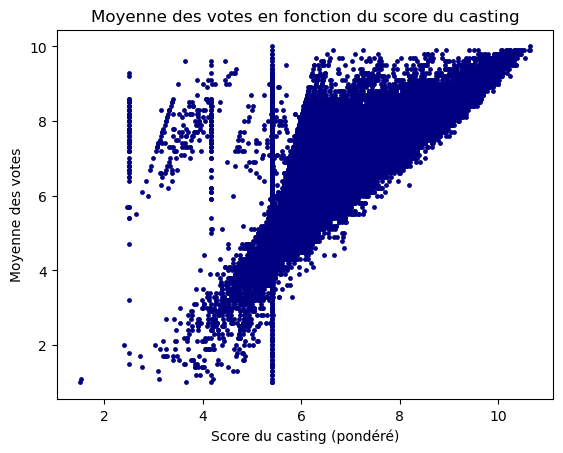

In [29]:
df_fusionné.plot(x='score_acteur', y='Note_moyenne', kind='scatter', s=6, c='navy')
plt.title("Moyenne des votes en fonction du score du casting")
plt.xlabel("Score du casting (pondéré)")
plt.ylabel("Moyenne des votes")
plt.show()

Le lien semble assez net. Les droites verticales sont malheureusement liées à l'initialisation de l'indicateur (ce sont les casts de novices), mais le résultat est plutôt satisfaisant.

Rebelote pour les réalisateurs.

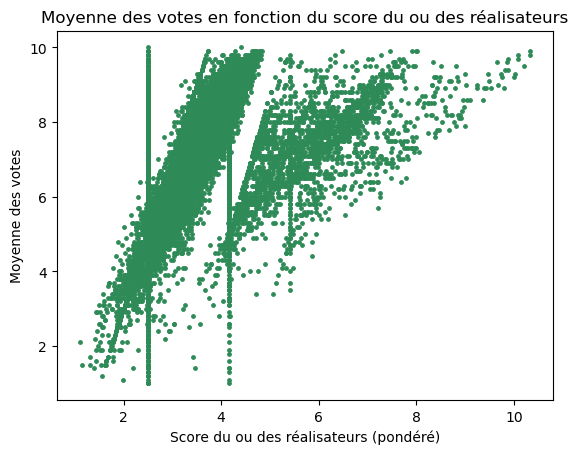

In [30]:
df_fusionné.plot(x='score_director', y='Note_moyenne', kind='scatter', s=6, c='seagreen')
plt.title("Moyenne des votes en fonction du score du ou des réalisateurs")
plt.xlabel("Score du ou des réalisateurs (pondéré)")
plt.ylabel("Moyenne des votes")
plt.show()

Cette fois le résultat est un peu moins clair, ce qui s'explique de la manière suivante : la création du score du film ne considère pas qu'une simple moyenne des scores des individus. Par exemple, il tient compte du fait que la présence de trois excellents acteurs dans un film vaut mieux qu'un seul. Ce raisonnement est sans doute caduque au sujet des réalisateurs. Reste qu'une corrélation apparaît assez nettement, ce qui est satisfaisant.

À présent munis de nos différentes variables explicatives, nous pouvons envisager de produire une régression linéaire de la note moyenne des films.

## Prédiction de la note des films

Nous pouvons exploiter nos différentes variables quantitatives (les 2 scores et la durée du film), mais nous avons également besoin d'utiliser des variables catégorielles, le genre, le certificat et le mois de publication. Pour conduire la régression, nous allons donc éclater ces variables en différentes indicatrices. Par exemple, une indicatrice qui prendra la valeur 1 si le film est un documentaire, et 0 sinon.

Commençons donc par définir une fonction qui binarise les valeurs possibles d'une colonne :

In [31]:
def binariseur(nom_de_colonne):
    #Cas liste
    if nom_de_colonne == 'genre' :
        df_explosé_temp = df_fusionné.explode (nom_de_colonne)
        #On récupère la liste des éléments unique dans la colonne
        Liste_elem_unique = df_explosé_temp[nom_de_colonne].unique()
        for element in Liste_elem_unique:
            #nouvelle colonne avec un un ou un zéro
            df_fusionné[element] = df_fusionné[nom_de_colonne].apply(lambda x: 1 if element in x else 0)
    #Cas sans liste
    else : 
      Liste_elem_unique = df_fusionné[nom_de_colonne].unique()
    for element in Liste_elem_unique:
        #Pour chaque élément unique,  on crée une nouvelle colonne dans le dataframe
        df_fusionné[element] = df_fusionné[nom_de_colonne].apply(lambda x: 1 if element == x else 0)

Maintenant, on appelle la fonction sur toutes les variables catégorielles.

In [32]:
binariseur('genre')
binariseur('contentRating')
binariseur('month_name')

TypeError: argument of type 'float' is not iterable

On peut finalement établir la régression sur toutes les variables que l'on considère.

In [110]:
#grande régression sur la note moyenne
df_regression = df_fusionné.copy()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_regression[['ID', 'duration', 'score_acteur', 'score_director',
                   'Jun', 'Oct', 'May', 'Jan', 'Aug', 'Mar', 'Apr', 'Dec', 'Sep','Jul', 'Feb', 'Nov',
                    "'Short'", "'Comedy'", "'Documentary'", "'Horror'", "'Fantasy'",
                    "'Action'", "'Adventure'", "'Family'", "'Animation'", "'Crime'",
                    "'Drama'", "'History'", "'War'", "'Sport'", "'Romance'",
                    "'Mystery'", "'Thriller'", "'Sci-Fi'", "'Western'", "'Biography'",
                    "'Music'", "'Musical'", "'Film-Noir'", "'News'", "'Talk-Show'",
                    "'Adult'", "'Game-Show'", "'Reality-TV'",
                    'tous publics+','6+','9+', '16','17', '14', '18','Public Averti','7',
                    'Accord parental','(Banned)',
                    'Éducatif', 'Approved', 'Not rated', 'tous publics', '13', '12']].dropna()
y = df_regression[['ID', 'Note_moyenne']].dropna()
df_filtrage = pd.merge(X, y, on='ID')

X = df_filtrage[['duration', 'score_acteur', 'score_director',
                   'Jun', 'Oct', 'May', 'Jan', 'Aug', 'Mar', 'Apr', 'Dec', 'Sep','Jul', 'Feb', 'Nov',
                    "'Short'", "'Comedy'", "'Documentary'", "'Horror'", "'Fantasy'",
                    "'Action'", "'Adventure'", "'Family'", "'Animation'", "'Crime'",
                    "'Drama'", "'History'", "'War'", "'Sport'", "'Romance'",
                    "'Mystery'", "'Thriller'", "'Sci-Fi'", "'Western'", "'Biography'",
                    "'Music'", "'Musical'", "'Film-Noir'", "'News'", "'Talk-Show'",
                    "'Adult'", "'Game-Show'", "'Reality-TV'",
                    'tous publics+','6+','9+', '16','17', '14', '18','Public Averti','7',
                    'Accord parental','(Banned)',
                    'Éducatif', 'Approved', 'Not rated', 'tous publics', '13', '12']]
y = df_filtrage['Note_moyenne']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

KeyError: '["\'Short\'", "\'Comedy\'", "\'Documentary\'", "\'Horror\'", "\'Fantasy\'", "\'Action\'", "\'Adventure\'", "\'Family\'", "\'Animation\'", "\'Crime\'", "\'Drama\'", "\'History\'", "\'War\'", "\'Sport\'", "\'Romance\'", "\'Mystery\'", "\'Thriller\'", "\'Sci-Fi\'", "\'Western\'", "\'Biography\'", "\'Music\'", "\'Musical\'", "\'Film-Noir\'", "\'News\'", "\'Talk-Show\'", "\'Adult\'", "\'Game-Show\'", "\'Reality-TV\'"] not in index'

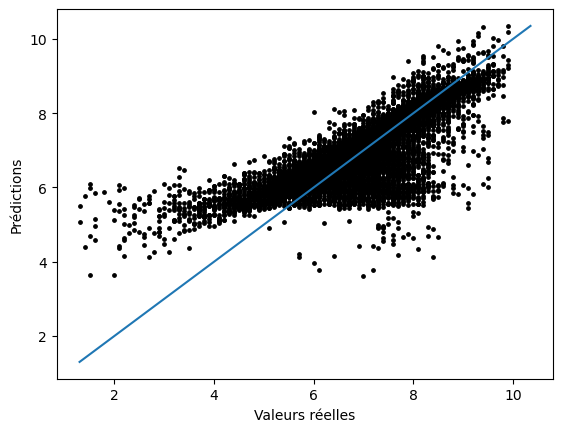

In [109]:
plt.scatter(y_test, y_pred, s=6, c='darkslateblue')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val])

In [50]:
#régression sur la note moyenne
df_regression = df_fusionné.copy()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_regression[['ID', 'duration', 'score_acteur', 'score_director']].dropna()
y = df_regression[['ID', 'Note_moyenne']].dropna()
df_filtrage = pd.merge(X, y, on='ID')

X = df_filtrage[['duration', 'score_acteur', 'score_director']]
y = df_filtrage['Note_moyenne']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

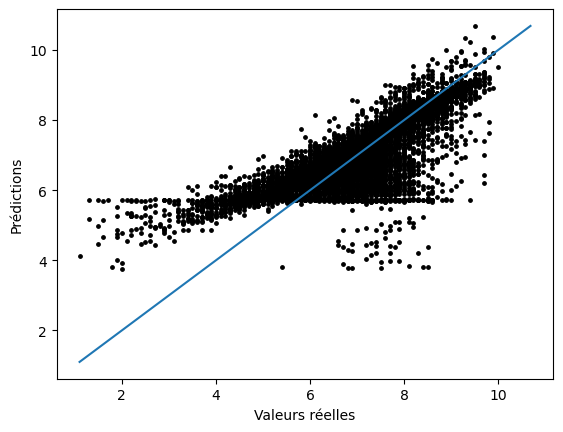

In [ ]:
plt.scatter(y_test, y_pred, s=6, c='black')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val])

In [ ]:
print(df_fusionné.columns.tolist()) 